In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Niloufar Baba Ahmadi MiniProject3 q2

### Imports

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

### Reading the datasets

In [3]:
with open("/content/drive/MyDrive/deep learning/MiniProject3/Dataset2/train.npy", "rb") as f:
    
    x_train = np.load(f, allow_pickle=True)
    y_train = np.load(f, allow_pickle=True)

with open("/content/drive/MyDrive/deep learning/MiniProject3/Dataset2/val.npy", "rb") as f:
    
    x_val = np.load(f, allow_pickle=True)
    y_val = np.load(f, allow_pickle=True)
    
with open("/content/drive/MyDrive/deep learning/MiniProject3/Dataset2/test.npy", "rb") as f:
    
    x_test = np.load(f, allow_pickle=True)
    y_test = np.load(f, allow_pickle=True)
    
print(f"{x_train.shape=} -- {y_train.shape=}")
print(f"{x_val.shape=} -- {y_val.shape=}")
print(f"{x_test.shape=} -- {y_test.shape=}")

x_train.shape=(50000, 784) -- y_train.shape=(50000,)
x_val.shape=(10000, 784) -- y_val.shape=(10000,)
x_test.shape=(10000, 784) -- y_test.shape=(10000,)


### Adjustments

- First, we normalize the pixel values to be between 0 and 1 by dividing each pixel value by 255. This helps to make the training process more efficient.
- Then, the images are also reshaped from their original 2D shape to a 1D vector since we expect the input data to be in the form of a 1D vector. 
- Finally, the labels are encoded using one-hot encoding, which is a way to represent categorical data in a binary format that is easier for the model to understand.

In [4]:
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape the images to be flat vectors
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Convert the labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)


### Activation functions

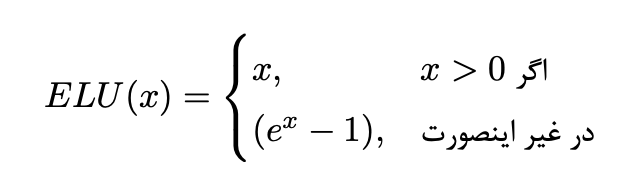

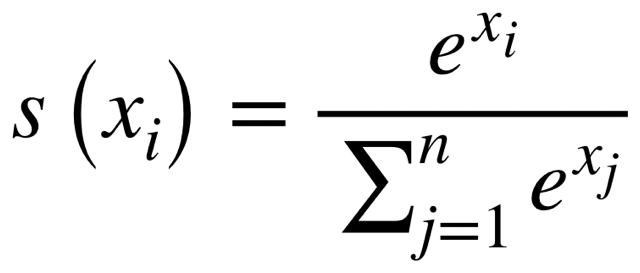

In [5]:
# Define the ELU activation function
def elu(x, alpha=1.0):

    return np.where(x < 0, alpha * (np.exp(x) - 1), x)

# Define the softmax function
def softmax(x):
    
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

### Cost Function

This function computes the cost function and its gradients for a given neural network with weight decay. 

It takes in four inputs:
- theta: a dictionary containing the weights and biases of the neural network
- X: the input data matrix
- y: the output labels matrix
- lambda_: the weight decay parameter

forward propagation steps of the neural network:

- calculates the weighted sum of the inputs with the first set of weights and biases.
- applies the ELU activation function to them to get the activation matrix 
- calculates the weighted sum of the activation matrix  - applies the softmax activation function to the second set of weights and biases to get the output matrix 
- calculates the cost function J
-- uses the cross-entropy loss function to measure the difference between the predicted output and the true output
- adds the weight decay term, which penalizes large weights, to the cost function using L2 regularization.

backward propagation steps of the neural network:
- calculates the error of the output layer 
- calculates the gradients of the second set of weights and biases 
- calculates the error of the first hidden layer  
- calculates the gradients of the first set of weights and biases 
- returns the cost function J and the gradients grad as a dictionary.

In [6]:
# Define the cost function with weight decay
def cost_function(theta, X, y, lambda_):

    m = len(y)
    Z1 = X @ theta['W1'] + theta['b1']
    A1 = elu(Z1)
    Z2 = A1 @ theta['W2'] + theta['b2']
    A2 = softmax(Z2)
    J = (-1/m) * np.sum(y * np.log(A2)) + (lambda_/(2*m)) * (np.sum(theta['W1']**2) + np.sum(theta['W2']**2))
    dZ2 = A2 - y
    dW2 = (1/m) * (A1.T @ dZ2) + (lambda_/m) * theta['W2']
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
    dA1 = dZ2 @ theta['W2'].T
    dZ1 = np.where(Z1 > 0, dA1, theta['alpha'] * (np.exp(Z1) - 1))
    dW1 = (1/m) * (X.T @ dZ1) + (lambda_/m) * theta['W1']
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
    grad = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
    
    return J, grad

### Train function

The train function takes in the following parameters: X, y, theta, num_epochs, batch_size, and lambda_.

X is the input data, y is the labels, theta is a dictionary containing the weights and biases for the neural network, num_epochs is the number of times to iterate over the entire dataset, batch_size is the number of samples to use for each update of the weights, and lambda_ is the regularization parameter for weight decay.

The function first computes the number of batches in the dataset based on the batch_size parameter. It then initializes empty lists to store the loss and accuracy values for each epoch.

For each epoch, the function iterates over each batch of the dataset. It performs forward propagation to compute the outputs of the neural network and the loss and accuracy for that batch. It then performs backpropagation to compute the gradients of the weights and biases. The weights and biases are updated using the gradients and the learning rate (theta['alpha']).

After each epoch, the average loss and accuracy for that epoch are computed and added to the loss and accuracy history lists. If the epoch number is a multiple of 10, the function prints out the epoch number, loss, and accuracy.

Finally, the function returns the updated theta dictionary and the loss and accuracy history lists.

Overall, this function trains a neural network using mini-batch gradient descent with weight decay regularization. It uses the cost_function to compute the loss and gradients, and updates the weights and biases based on the gradients and learning rate. It also tracks the loss and accuracy for each epoch to monitor the progress of the training.

In [7]:
def train(X, y, theta, num_epochs, batch_size, lambda_):
    
    num_batches = len(X) // batch_size
    loss_history = []
    accuracy_history = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for i in range(num_batches):
            X_batch = X[i*batch_size:(i+1)*batch_size]
            y_batch = y[i*batch_size:(i+1)*batch_size]

            # Forward propagation
            z1 = X_batch @ theta['W1'] + theta['b1']
            a1 = elu(z1)
            z2 = a1 @ theta['W2'] + theta['b2']
            a2 = softmax(z2)

            # Compute loss and accuracy
            l, grad = cost_function(theta, X_batch, y_batch, lambda_)
            epoch_loss += l
            epoch_accuracy += np.mean(np.argmax(a2, axis=1) == np.argmax(y_batch, axis=1))

            # Backpropagation
            dZ2 = a2 - y_batch
            dW2 = (1/len(y_batch)) * (a1.T @ dZ2) + (lambda_/len(y_batch)) * theta['W2']
            db2 = (1/len(y_batch)) * np.sum(dZ2, axis=0, keepdims=True)
            dA1 = dZ2 @ theta['W2'].T
            dZ1 = np.where(z1 > 0, dA1, theta['alpha'] * (np.exp(z1) - 1))
            dW1 = (1/len(y_batch)) * (X_batch.T @ dZ1) + (lambda_/len(y_batch)) * theta['W1']
            db1 = (1/len(y_batch)) * np.sum(dZ1, axis=0, keepdims=True)

            # Update weights and biases
            theta['W2'] -= theta['alpha'] * dW2
            theta['b2'] -= theta['alpha'] * db2
            theta['W1'] -= theta['alpha'] * dW1
            theta['b1'] -= theta['alpha'] * db1

        # Compute average loss and accuracy for the epoch
        epoch_loss /= num_batches
        epoch_accuracy /= num_batches
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)

        # progress tracker
        if (epoch+1) % 10 == 0:

            print(f"Epoch {epoch+1}/{num_epochs}: loss={epoch_loss:.4f}, accuracy={epoch_accuracy:.4f}")
    
    return theta, loss_history, accuracy_history


### Predict

This function takes in a set of input data X and a trained neural network parameters theta, and returns the predicted class labels for each input in X.

- It first computes the output of the first layer by taking the dot product of X and the weight matrix W1 and adding the bias term b1. (The @ symbol is the matrix multiplication operator in NumPy.)
- It then applies the ELU activation function to the output of the first layer to get the activations of the first layer.
- It computes the output of the second (output) layer by taking the dot product of the activations of the first layer and the weight matrix W2, and adding the bias term b2.
- It applies the softmax activation function to the output of the second layer to get the predicted probabilities for each class.
- Finally, it returns the class with the highest probability for each input by using the np.argmax function with axis=1 to get the index of the highest probability for each input.

In [8]:
def predict(X, theta):
    z1 = X @ theta['W1'] + theta['b1']
    a1 = elu(z1)
    z2 = a1 @ theta['W2'] + theta['b2']
    a2 = softmax(z2)
    return np.argmax(a2, axis=1)

The 3 cells bellow were executed in order to debug my code, so you can ignore it.

In [9]:
# Initialize the weights and biases
input_size = 784
hidden_size = 20
output_size = 10
alpha = 0.01 # learning rate
np.random.seed(0) 

theta = {

    'W1': np.random.randn(input_size, hidden_size) * np.sqrt(2/input_size),
    'b1': np.zeros((1, hidden_size)),
    'W2': np.random.randn(hidden_size, output_size) * np.sqrt(2/hidden_size),
    'b2': np.zeros((1, output_size)),
    'alpha': alpha
}

# Define the hyperparameters
num_epochs = 50
batch_size = 32
lambda_ = 0.01

In [10]:
train(x_train, y_train, theta, num_epochs, batch_size, lambda_)

Epoch 10/50: loss=0.4336, accuracy=0.8547
Epoch 20/50: loss=0.3994, accuracy=0.8666
Epoch 30/50: loss=0.3806, accuracy=0.8742
Epoch 40/50: loss=0.3675, accuracy=0.8793
Epoch 50/50: loss=0.3575, accuracy=0.8837


({'W1': array([[ 0.06966906,  0.01585443,  0.03866323, ..., -0.00844958,
           0.01226468, -0.03410595],
         [-0.10192868,  0.02659973,  0.0352945 , ...,  0.04849593,
          -0.01614347, -0.01315301],
         [-0.04646285, -0.05315806, -0.05837711, ...,  0.01472491,
          -0.03343193, -0.02229089],
         ...,
         [-0.00894508, -0.01807932,  0.02596615, ...,  0.00638577,
          -0.03998786,  0.0134967 ],
         [ 0.02942599, -0.05203899, -0.00790645, ...,  0.06387722,
           0.03054037,  0.04542321],
         [ 0.07984175, -0.05072388, -0.02924646, ..., -0.01561376,
          -0.03687945,  0.00981601]]),
  'b1': array([[ 0.08388553,  0.52863952,  0.58560147, -0.08898811,  0.5451698 ,
          -0.14142329, -0.44180954,  0.24609543,  0.25949724,  0.00264102,
          -0.45424481,  0.10451104,  0.4751192 ,  0.6112147 ,  0.50900103,
           0.39205987,  0.03258682,  0.30060119, -0.24109163, -0.50405319]]),
  'W2': array([[-0.58372171, -0.66421334,  0.

In [11]:
predictions = predict(x_val, theta)
accuracy = np.mean(predictions == np.argmax(y_val, axis=1))
print(f"Test accuracy: {accuracy:.4f}")


Test accuracy: 0.8681


### Fine tuning the hyper parameters

I started by fine tuning the learning rate and weight decay rate. 

To do that:

- Create a simple nn model with a single hidden layer (When building a neural network model, it is recommended to start with a simple architecture and gradually increase its complexity as needed, based on the performance on a validation set.)

- Train the model using different combinations of learning rate and weight decay rate

In [16]:
alpha_ls = [0.1, 0.01, 0.001]
lambda_ls = [0.01, 0.001, 0.0001]
acc_ls = []
bias_ls = []
variance_ls = []

for i in alpha_ls:

    for j in lambda_ls:

        # Initialize the weights and biases
        input_size = 784
        hidden_size = 1
        output_size = 10
        alpha = i
        np.random.seed(0)

        theta = {

            'W1': np.random.randn(input_size, hidden_size) * np.sqrt(2/input_size),
            'b1': np.zeros((1, hidden_size)),
            'W2': np.random.randn(hidden_size, output_size) * np.sqrt(2/hidden_size),
            'b2': np.zeros((1, output_size)),
            'alpha': alpha
        }

        # Define the hyperparameters
        num_epochs = 50
        batch_size = 32
        lambda_ = j

        train(x_train, y_train, theta, num_epochs, batch_size, lambda_)

        predictions = predict(x_val, theta)
        accuracy = np.mean(predictions == np.argmax(y_val, axis=1))
        bias = np.mean(np.abs(np.mean(predictions) - np.argmax(y_val, axis=1)))
        variance = np.mean(np.var(predictions))

        acc_ls.append(accuracy)
        bias_ls.append(bias)
        variance_ls.append(variance)

        print(f"Alpha: {alpha:.4f}, Lambda: {lambda_:.4f}")
        print(f"Validation accuracy: {accuracy:.4f}, Bias: {bias:.4f}, Variance: {variance:.4f}")
        print("-----------------------------------")

Epoch 10/50: loss=1.3896, accuracy=0.3921
Epoch 20/50: loss=1.3680, accuracy=0.4028
Epoch 30/50: loss=1.3623, accuracy=0.4059
Epoch 40/50: loss=1.3610, accuracy=0.4074
Epoch 50/50: loss=1.3615, accuracy=0.4081
Alpha: 0.1000, Lambda: 0.0100
Validation accuracy: 0.4077, Bias: 2.5702, Variance: 6.6547
-----------------------------------
Epoch 10/50: loss=1.3848, accuracy=0.3909
Epoch 20/50: loss=1.3605, accuracy=0.4022
Epoch 30/50: loss=1.3556, accuracy=0.4060
Epoch 40/50: loss=1.3534, accuracy=0.4079
Epoch 50/50: loss=1.3530, accuracy=0.4094
Alpha: 0.1000, Lambda: 0.0010
Validation accuracy: 0.4107, Bias: 2.5722, Variance: 6.6674
-----------------------------------
Epoch 10/50: loss=1.3842, accuracy=0.3913
Epoch 20/50: loss=1.3599, accuracy=0.4020
Epoch 30/50: loss=1.3547, accuracy=0.4053
Epoch 40/50: loss=1.3525, accuracy=0.4079
Epoch 50/50: loss=1.3517, accuracy=0.4096
Alpha: 0.1000, Lambda: 0.0001
Validation accuracy: 0.4111, Bias: 2.5718, Variance: 6.6617
----------------------------

As you see, we get the best results when Learning Rate = 0.01 and Weight Decay Rate = 0.001. Now we will use that to find the best number of hidden layers.

In [17]:
hidden_ls = [10, 20, 30, 40, 50]
acc_ls = []

for i in hidden_ls:

        # Initialize the weights and biases
        input_size = 784
        hidden_size = i
        output_size = 10
        alpha = 0.01
        np.random.seed(0)

        theta = {

            'W1': np.random.randn(input_size, hidden_size) * np.sqrt(2/input_size),
            'b1': np.zeros((1, hidden_size)),
            'W2': np.random.randn(hidden_size, output_size) * np.sqrt(2/hidden_size),
            'b2': np.zeros((1, output_size)),
            'alpha': alpha
        }

        # Define the hyperparameters
        num_epochs = 50
        batch_size = 32
        lambda_ = 0.001

        train(x_train, y_train, theta, num_epochs, batch_size, lambda_)

        predictions = predict(x_val, theta)
        accuracy = np.mean(predictions == np.argmax(y_val, axis=1))
        bias = np.mean(np.abs(np.mean(predictions) - np.argmax(y_val, axis=1)))
        variance = np.mean(np.var(predictions))

        acc_ls.append(accuracy)
        bias_ls.append(bias)
        variance_ls.append(variance)

        print(f"Alpha: {alpha:.4f}, Lambda: {lambda_:.4f}")
        print(f"Validation accuracy: {accuracy:.4f}, Bias: {bias:.4f}, Variance: {variance:.4f}")
        print("-----------------------------------")

Epoch 10/50: loss=0.4307, accuracy=0.8495
Epoch 20/50: loss=0.3991, accuracy=0.8599
Epoch 30/50: loss=0.3835, accuracy=0.8655
Epoch 40/50: loss=0.3731, accuracy=0.8691
Epoch 50/50: loss=0.3655, accuracy=0.8715
Alpha: 0.0100, Lambda: 0.0010
Validation accuracy: 0.8583, Bias: 2.4945, Variance: 8.4161
-----------------------------------
Epoch 10/50: loss=0.4179, accuracy=0.8551
Epoch 20/50: loss=0.3798, accuracy=0.8676
Epoch 30/50: loss=0.3572, accuracy=0.8760
Epoch 40/50: loss=0.3412, accuracy=0.8814
Epoch 50/50: loss=0.3284, accuracy=0.8850
Alpha: 0.0100, Lambda: 0.0010
Validation accuracy: 0.8680, Bias: 2.4944, Variance: 8.4109
-----------------------------------
Epoch 10/50: loss=0.4179, accuracy=0.8561
Epoch 20/50: loss=0.3826, accuracy=0.8678
Epoch 30/50: loss=0.3610, accuracy=0.8736
Epoch 40/50: loss=0.3454, accuracy=0.8791
Epoch 50/50: loss=0.3314, accuracy=0.8847
Alpha: 0.0100, Lambda: 0.0010
Validation accuracy: 0.8638, Bias: 2.4941, Variance: 8.4833
----------------------------

As evident, the best number of hidden layers is 40. Now that we are done fine tuning, we will train our model to predict the test data.

### The relationship between bias and varience and the parameters

- Weight decay is a method for preventing overfitting by adding a penalty term to the loss function. By reducing the complexity of the our model, weight decay reduces variance.

- Learning rate determines the size of the steps taken during the gradient descent optimization process. If the learning rate is too high, we have a high variance. If the learning rate is too low, the model may not converge at all, leading to a high bias.

- In general, a model with more hidden layers has the potential to learn more complex patterns and capture more intricate relationships in the data, which can lead to lower bias. However, having more hidden layers can also make the model more prone to overfitting, resulting in higher variance. You can see here that as we increase the number of hidden layers the varience decreases and bias increases.

### Training phase

We will train the model using the parameters we found.

In [25]:
# Initialize the weights and biases
input_size = 784
hidden_size = 40
output_size = 10
alpha = 0.01 # learning rate
np.random.seed(0) 

theta = {

    'W1': np.random.randn(input_size, hidden_size) * np.sqrt(2/input_size),
    'b1': np.zeros((1, hidden_size)),
    'W2': np.random.randn(hidden_size, output_size) * np.sqrt(2/hidden_size),
    'b2': np.zeros((1, output_size)),
    'alpha': alpha
}

# Define the hyperparameters
num_epochs = 50
batch_size = 32
lambda_ = 0.001

In [26]:
train(x_train, y_train, theta, num_epochs, batch_size, lambda_)

Epoch 10/50: loss=0.4143, accuracy=0.8560
Epoch 20/50: loss=0.3733, accuracy=0.8698
Epoch 30/50: loss=0.3480, accuracy=0.8791
Epoch 40/50: loss=0.3307, accuracy=0.8854
Epoch 50/50: loss=0.3176, accuracy=0.8892


({'W1': array([[ 0.08719368,  0.01946095,  0.04789518, ...,  0.05920573,
          -0.01910959, -0.01506554],
         [-0.05292256, -0.06993424, -0.08377367, ..., -0.02790667,
          -0.01537488,  0.00338476],
         [-0.06411303,  0.04507484,  0.02384173, ..., -0.0045742 ,
           0.02995343,  0.04666242],
         ...,
         [-0.12761546, -0.04660961,  0.08525314, ...,  0.07936167,
          -0.04219316, -0.04505412],
         [ 0.02800691,  0.01240789,  0.05490098, ...,  0.05196754,
           0.02155752,  0.02211256],
         [-0.08659681,  0.04818785,  0.04938478, ...,  0.0084939 ,
           0.01161087, -0.01562394]]),
  'b1': array([[-0.47007641,  0.32233418, -0.00202487, -0.00616345,  0.25642782,
          -0.09999414,  0.55490383,  0.13092115, -0.10940352, -0.16085589,
           0.57483261,  0.10554514,  0.1994298 , -0.54842502, -0.00952544,
           0.70759542,  0.0346081 ,  0.2878635 ,  0.32251442, -0.02815369,
           0.34300204, -0.00226749, -0.16942547,

### Predicting the test data

Using the weights and bias found, we will predict the test data and finf its accuracy.

In [28]:
predictions = predict(x_test, theta)

accuracy = np.mean(predictions == np.argmax(y_test, axis=1))
bias = np.mean(np.abs(np.mean(predictions) - np.argmax(y_test, axis=1)))
variance = np.mean(np.var(predictions))

print(f"test accuracy: {accuracy:.4f}, Bias: {bias:.4f}, Variance: {variance:.4f}")
print("-----------------------------------")


test accuracy: 0.8597, Bias: 2.5000, Variance: 8.4132
-----------------------------------
